In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
n = 40;
F = 8;

# Lorenz 96 Model 

$$\frac{dx_i}{dt} = (x_{i+1}-x_{i-2}) \cdot x_{i-1} - x_i + \underbrace{F}_{\text{External Force}},\, \text{ for $1 \le i \le n$},\,$$
where periodic boundary conditions are assumed.

In [6]:
def lorenz96(x, t):
  n = len(x);
  dx = [(x[np.mod(i+1,n)]-x[i-2])*x[i-1]-x[i]+F for i in range(0,n)];
  return dx;

1. Initial Condition - Long Term Propagation

In [7]:
np.random.seed(seed=10);
x0 = np.random.randn(n);
t = np.arange(0,30,0.01);
x = odeint(lorenz96,x0,t);
xt = x[-1,:]; #Initial Condition


2. Initial Background

In [8]:
xb = xt+0.05*np.random.randn(n);

## Propagate xb
x = odeint(lorenz96, xb, t);
xb = x[-1,:]; #Background state (initial)

## Propagate xt
xs = odeint(lorenz96, xt, t);
xt = xs[-1,:]; #xb(k) - xt(k) en ambos k es el mismo

#sns.set_style('darkgrid')
#plt.plot(x[:,1]);
#plt.plot(xs[:,1]);


Creating the initial ensemble

In [9]:
N_total = 200;
ones = np.ones(N_total);

#Initial ensemble not consistent with model dynamics
XB = np.outer(ones,xb) + 0.05*np.random.randn(N_total,n);

#Propagate ensemble
time = np.arange(0,10,0.01);
M = len(time);
snapshots = np.zeros((N_total,M,n));
for e in range(0,N_total):
  sol = odeint(lorenz96,XB[e,:],time); #in Re^{M \times n}
  snapshots[e,:,:] = sol;
  XB[e,:] = sol[-1,:];

#Propagate initial condition to get to time XB(t)
xSt = odeint(lorenz96,xt,time);
xt = xSt[-1,:]; 

# Projectors

$${\bf X}^b = {\bf U} \cdot \boldsymbol{\Sigma} \cdot {\bf V}^T \rightarrow {\bf X}^b\cdot {\bf V} \cdot \boldsymbol{\Sigma}^{-1} = {\bf U} $$

In [10]:
import scipy.linalg as lan

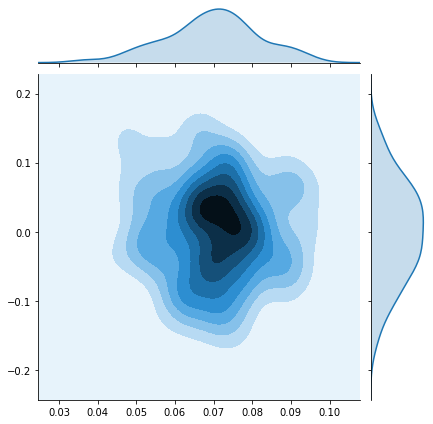

In [11]:
U,S,V = lan.svd(XB);
sns.jointplot(x=U[:,0],y=U[:,1],kind='kde');

In [13]:
N = 20;
ind = np.random.permutation(np.arange(0,N_total))[:N];
print(ind)

[ 33 112  68 186  24 181  81 184 103 147  99  92 199 163  32  61 100 101
 141 130]


(20, 40)


<Figure size 720x576 with 0 Axes>

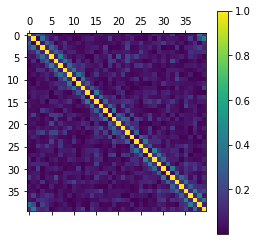

<Figure size 720x576 with 0 Axes>

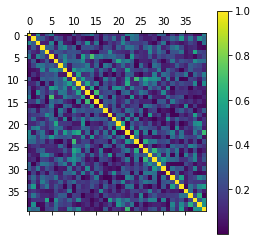

In [19]:
plt.figure(figsize=(10,8))
plt.matshow(np.abs(np.corrcoef(XB.transpose())));
plt.colorbar()

XB_0 = XB[ind,:];
print(np.shape(XB_0))
plt.figure(figsize=(10,8))
plt.matshow(np.abs(np.corrcoef(XB_0.transpose())));
plt.colorbar()



# EnKF
\begin{eqnarray}
{\bf X}^a = {\bf X}^b + {\bf P}^b \cdot {\bf H}^T \cdot {\bf Z}
\end{eqnarray}

In [20]:
np.random.seed(seed=10);

time_step = 0.01;
T = 15; #Number of time steps to simulate

I = np.eye(n,n);

N = 20;
ind = np.random.permutation(np.arange(0,N_total))[:N];

#Initial variables for the tests.
xt_k = xt.copy();
XB_k = XB[ind,:].copy().transpose();

#Number of observed components
p = 0.8;
m = int(round(p*n));
sig_obs = 0.01;
R_k = (sig_obs**2)*np.eye(m,m);

errorb_k = np.zeros(T);
errora_k = np.zeros(T);


for k in range(0,T):

  print(f'Assimilation Cycle {k}');

  #Prior parameters
  xb_k = np.mean(XB_k,1);
  PB_k = np.cov(XB_k);

  #Prior error
  errorb_k[k] = np.linalg.norm(xt_k-xb_k);

  #Observation at time step k - we are simulating an observation
  obs_comp = np.random.permutation(n);
  obs_comp = obs_comp[0:m];
  H_k = I[obs_comp,:];
  err_obs_k = sig_obs*np.random.randn(m);
  y_k = H_k@xt_k + err_obs_k;

  #Synthetic observations
  Eobs_k = sig_obs*np.random.randn(m,N);
  Yobs_k = np.outer(y_k,np.ones(N)) + Eobs_k;

  #Matrix of innovation ob the synthetic observations
  D_k = Yobs_k-H_k@XB_k; #np.matmul(H_k,XB_k)

  #Innovation matrix
  IN_k = R_k + H_k@PB_k@H_k.transpose();
  Z_k = np.linalg.solve(IN_k,D_k);

  #Analysis ensemble (posterior ensemble)
  XA_k = XB_k + PB_k@H_k.transpose()@Z_k;
  xa_k = np.mean(XA_k,1);

  #Posterior error
  errora_k[k] = np.linalg.norm(xt_k-xa_k);

  #Forecast Step
  for e in range(0,N):
    XA_e_S = odeint(lorenz96,XA_k[:,e],[0,time_step]);
    XB_k[:,e] = XA_e_S[-1,:];
  
  #Forecast of actual state (for reference)
  xt_S = odeint(lorenz96,xt_k,[0,time_step]);
  xt_k = xt_S[-1,:];



print(errorb_k)
print(errora_k)

Assimilation Cycle 0
Assimilation Cycle 1
Assimilation Cycle 2
Assimilation Cycle 3
Assimilation Cycle 4
Assimilation Cycle 5
Assimilation Cycle 6
Assimilation Cycle 7
Assimilation Cycle 8
Assimilation Cycle 9
Assimilation Cycle 10
Assimilation Cycle 11
Assimilation Cycle 12
Assimilation Cycle 13
Assimilation Cycle 14
[22.86637437 16.64595391 12.89037931 12.76004728 12.52844345 12.33305387
 12.22513409 12.05957387 11.93692399 11.79185671 11.65108694 11.55005744
 11.45280734 11.35644274 11.2866094 ]
[16.53935748 12.93819237 12.82048739 12.6104284  12.41840463 12.30169921
 12.13311806 12.00404414 11.8473026  11.69742513 11.58275617 11.47334595
 11.36302787 11.27690584 11.18162312]


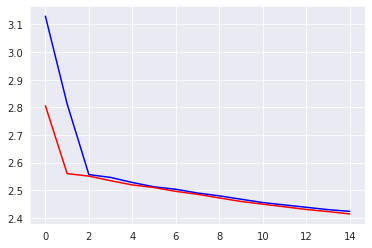

In [22]:
sns.set_style('darkgrid')
plt.plot(np.log(errorb_k),'b');
plt.plot(np.log(errora_k),'r');

# EnKF
\begin{eqnarray}
{\bf X}^a = {\bf X}^b + \boldsymbol{\Delta}\widehat{\bf X}^b \cdot {\bf Q}^T \cdot {\bf Z}
\end{eqnarray}

In [38]:
np.random.seed(seed=20);

time_step = 0.01;
T = 15; #Number of time steps to simulate

I = np.eye(n,n);

N = 20;
ind = np.random.permutation(np.arange(0,N_total))[:N];

#Initial variables for the tests.
xt_k = xt.copy();
XB_k = XB[ind,:].copy().transpose();

#Number of observed components
p = 0.8;
m = int(round(p*n));
sig_obs = 0.01;
R_k = (sig_obs**2)*np.eye(m,m);

errorb_k = np.zeros(T);
errora_k = np.zeros(T);


for k in range(0,T):

  print(f'Assimilation Cycle {k}');

  #Prior parameters
  xb_k = np.mean(XB_k,1);
  PB_k = np.cov(XB_k);

  #Prior error
  errorb_k[k] = np.linalg.norm(xt_k-xb_k);

  #Observation at time step k - we are simulating an observation
  obs_comp = np.random.permutation(n);
  obs_comp = obs_comp[0:m];
  H_k = I[obs_comp,:];
  err_obs_k = sig_obs*np.random.randn(m);
  y_k = H_k@xt_k + err_obs_k;

  #Synthetic observations
  Eobs_k = sig_obs*np.random.randn(m,N);
  Yobs_k = np.outer(y_k,np.ones(N)) + Eobs_k;

  #Matrix of innovation ob the synthetic observations
  D_k = Yobs_k-H_k@XB_k; #np.matmul(H_k,XB_k)

  DX_k = XB_k-np.outer(xb_k,np.ones(N));
  DXG_k = 1/(np.sqrt(N-1))*DX_k;
  #Innovation matrix
  Q_k = H_k@DXG_k;
  IN_k = R_k + Q_k@Q_k.transpose();
  Z_k = np.linalg.solve(IN_k,D_k);

  #Analysis ensemble (posterior ensemble)
  XA_k = XB_k + DXG_k@(Q_k.transpose()@Z_k);
  xa_k = np.mean(XA_k,1);

  #Posterior error
  errora_k[k] = np.linalg.norm(xt_k-xa_k);

  #Forecast Step
  for e in range(0,N):
    XA_e_S = odeint(lorenz96,XA_k[:,e],[0,time_step]);
    XB_k[:,e] = XA_e_S[-1,:];
  
  #Forecast of actual state (for reference)
  xt_S = odeint(lorenz96,xt_k,[0,time_step]);
  xt_k = xt_S[-1,:];



print(errorb_k)
print(errora_k)

Assimilation Cycle 0
Assimilation Cycle 1
Assimilation Cycle 2
Assimilation Cycle 3
Assimilation Cycle 4
Assimilation Cycle 5
Assimilation Cycle 6
Assimilation Cycle 7
Assimilation Cycle 8
Assimilation Cycle 9
Assimilation Cycle 10
Assimilation Cycle 11
Assimilation Cycle 12
Assimilation Cycle 13
Assimilation Cycle 14
[20.24445917 19.68950831 16.82355063 16.22319712 16.13752042 15.93241675
 15.78545116 15.57297651 15.47755816 15.41080463 15.35808235 15.33861333
 15.35586836 15.38034088 15.34602884]
[19.93218013 16.99438958 16.35523993 16.26010281 16.05720064 15.88588373
 15.63050522 15.51330874 15.42972744 15.34741892 15.29591369 15.28625649
 15.28981532 15.24729691 15.20297633]


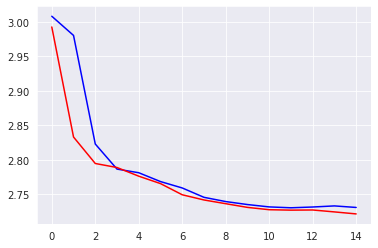

In [39]:
sns.set_style('darkgrid')
plt.plot(np.log(errorb_k),'b');
plt.plot(np.log(errora_k),'r');

[ 5.32323874  4.43271984  1.6150781  -2.61286679  2.186321    5.14869927
  6.19727832  1.13789392 -1.18815101  4.21923987  8.04413912  0.42417444
  1.49951315 -0.83585376  1.22797829  7.78079872  1.43555436  0.18186149
  1.02397275  5.96953459  6.95838736 -2.88766856  3.8021494   3.75707858
  6.36863916  5.67402494  1.33765706  3.7266527   2.81005085  2.0671381
  2.80208844  3.61067042 -2.80417257 -2.35101892 -0.26006672  8.07021562
  5.32545013 -1.9737032  -1.15314962  1.65569278]
(40, 40)
19


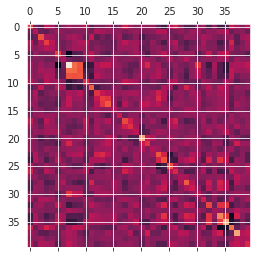

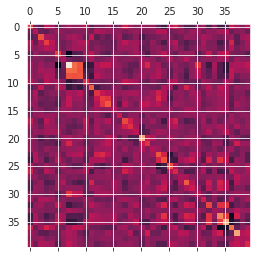

In [35]:
xb_k = np.mean(XB_k,1);
print(xb_k)

PB_k = np.cov(XB_k)
print(np.shape(PB_k))

print(np.linalg.matrix_rank(PB_k))

DX_k = XB_k-np.outer(xb_k,np.ones(N));

PB_Q_k = (1/(N-1))*DX_k@DX_k.transpose(); #Covariance

plt.matshow(PB_k)


plt.matshow(PB_Q_k)